## Clustering Statistics

This notebook demonstrates how to calculate the 2-point clustering statistics from DESI data. To generate the window power spectrum, the following are required:
- Number of random mocks: ELG: 10; LRG: 8 ;QSO: 4 (clustering.ran.fits)
- One data file. (clustering.dat.fits)

The power spectrum is calculated with`compute_pk.sh`, which uses the `cosmodesi` environment and the `pkrun.py` tool to compute the power spectrum.

In [6]:
!source ./scripts/compute_pk.sh

/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `module'
/bin/bash: ml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `ml'
sh: ml: line 1: syntax error: unexpected end of file
sh: error importing function definition for `ml'
sh: module: line 1: syntax error: unexpected end of file
sh: error importing function definition for `module'
sh: ml: line 1: syntax error: unexpected end of file
sh: error importing function definition for `ml'
sh: module: line 1: syntax error: unexpected end of file
sh: error importing function definition for `module'
srun: job 31908583 queued and waiting for resources
srun: job 31908583 has been allocated resources
^C


In [1]:
# loading the desilike enviroment
import os
import glob
import numpy as np
from cosmoprimo.fiducial import DESI
from desilike.theories.galaxy_clustering import DirectPowerSpectrumTemplate, ShapeFitPowerSpectrumTemplate, StandardPowerSpectrumTemplate
from desilike.theories.galaxy_clustering import FOLPSTracerPowerSpectrumMultipoles, FOLPSRCTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable, BoxFootprint, ObservablesCovarianceMatrix
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike import plotting

from matplotlib import pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 14
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from desilike import setup_logging
setup_logging()

2024-10-15 12:21:19.256487: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.77). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [8]:
# load the pk file and the covariance matrix from the Ezmocks, the pk calculated from the pkrun.py
pk_fn = '/global/homes/s/shengyu/project_rc/main/data/pk/pkpoles_ELG_LOPnotqso_NGC_0.8_1.1_default_FKP_lin_thetacut0.05.npy'

cov_dir = '/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/'
cov_fn = 'pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy'

cov_fns = []
for i in range(100, 200):
    mock_dir = f'mock{i}/pk/'
    cov_fns.extend(glob.glob(os.path.join(cov_dir,  mock_dir, cov_fn), recursive=True))
print(len(cov_fns))

100


In [3]:
# set the k bins
kmin     = 0.005
kmax     = 0.2
binning  = 0.005
k_ev     = np.arange(kmin, kmax+0.001, binning)
klim     = {ell*2: (kmin,kmax,binning) for ell in range(2)}

cosmo = DESI()
template = DirectPowerSpectrumTemplate(fiducial='DESI')
theory = FOLPSRCTracerPowerSpectrumMultipoles(template=template)
print(theory.varied_params)
# footprint = BoxFootprint(volume=1e10, nbar=1e-3)
# covariance = ObservablesCovarianceMatrix(cov_fns, footprints=footprint)()
observable = TracerPowerSpectrumMultipolesObservable(data= pk_fn, 
                                                     klim=klim, 
                                                     covariance = cov_fns,)
likelihood = ObservablesGaussianLikelihood(observable)
likelihood()

ParameterCollection(['h', 'omega_cdm', 'omega_b', 'logA', 'b1', 'b2', 'bs', 'alpha0', 'alpha2', 'alpha4', 'sn0', 'sn2', 'fc'])
[000004.98] [0/1] 10-15 11:55  TracerPowerSpectrumMultipolesObservable INFO     Loading 1 file ['/global/homes/s/shengyu/project_rc/main/data/pk/pkpoles_ELG_LOPnotqso_NGC_0.8_1.1_default_FKP_lin_thetacut0.05.npy'].
[000005.05] [0/1] 10-15 11:55  TracerPowerSpectrumMultipolesObservable INFO     Loading 100 files [/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock100/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock120/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock140/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /glo

Array(-983.82666601, dtype=float64)

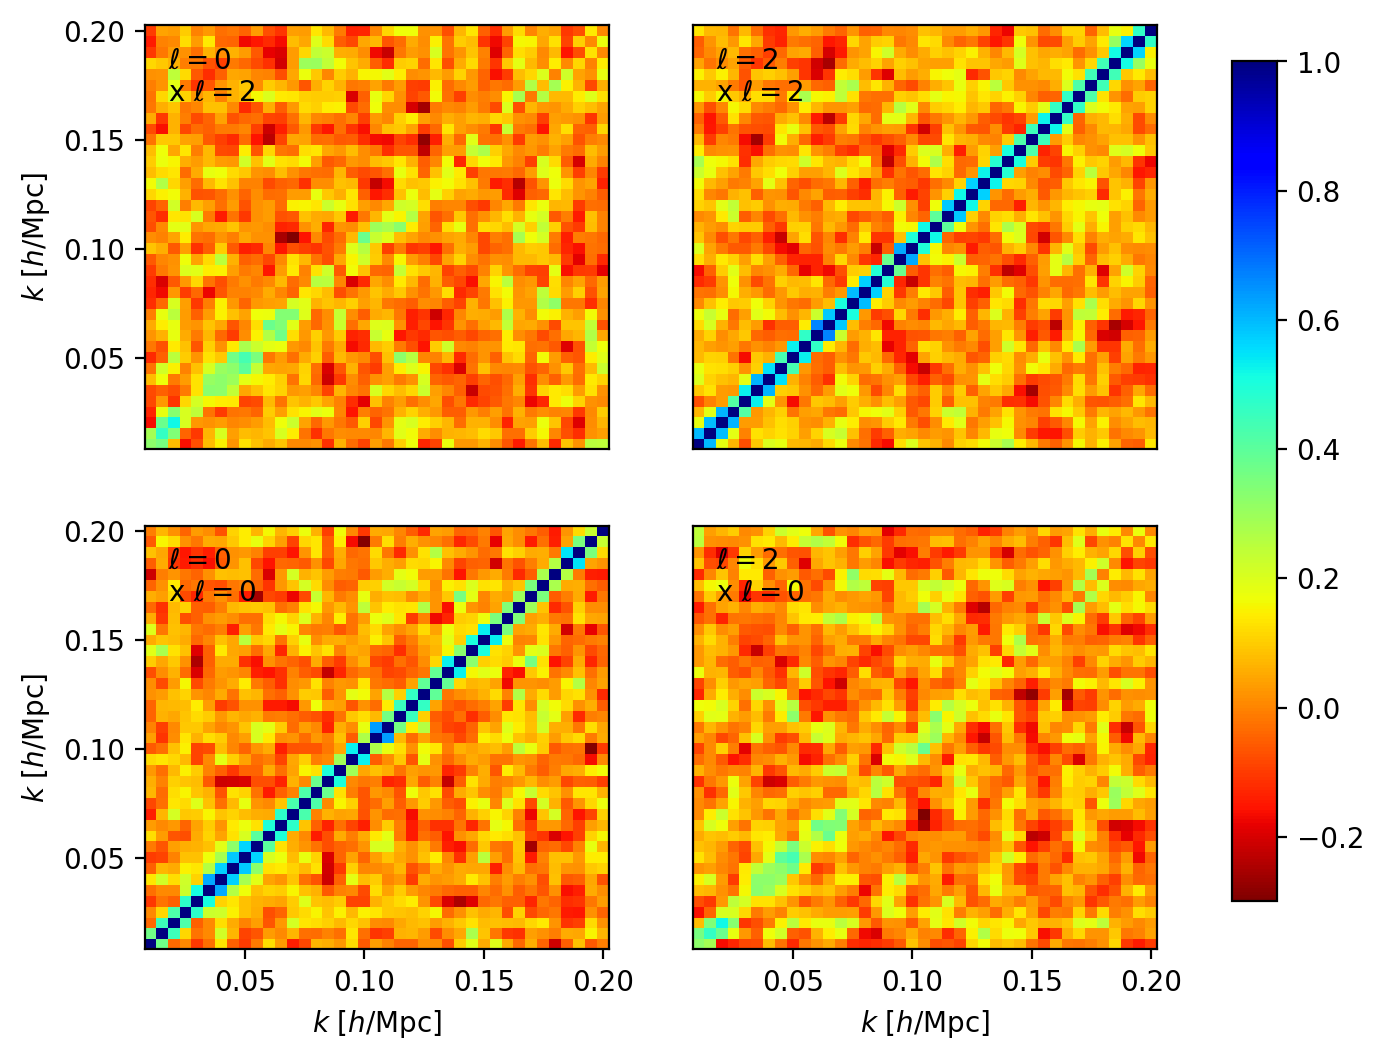

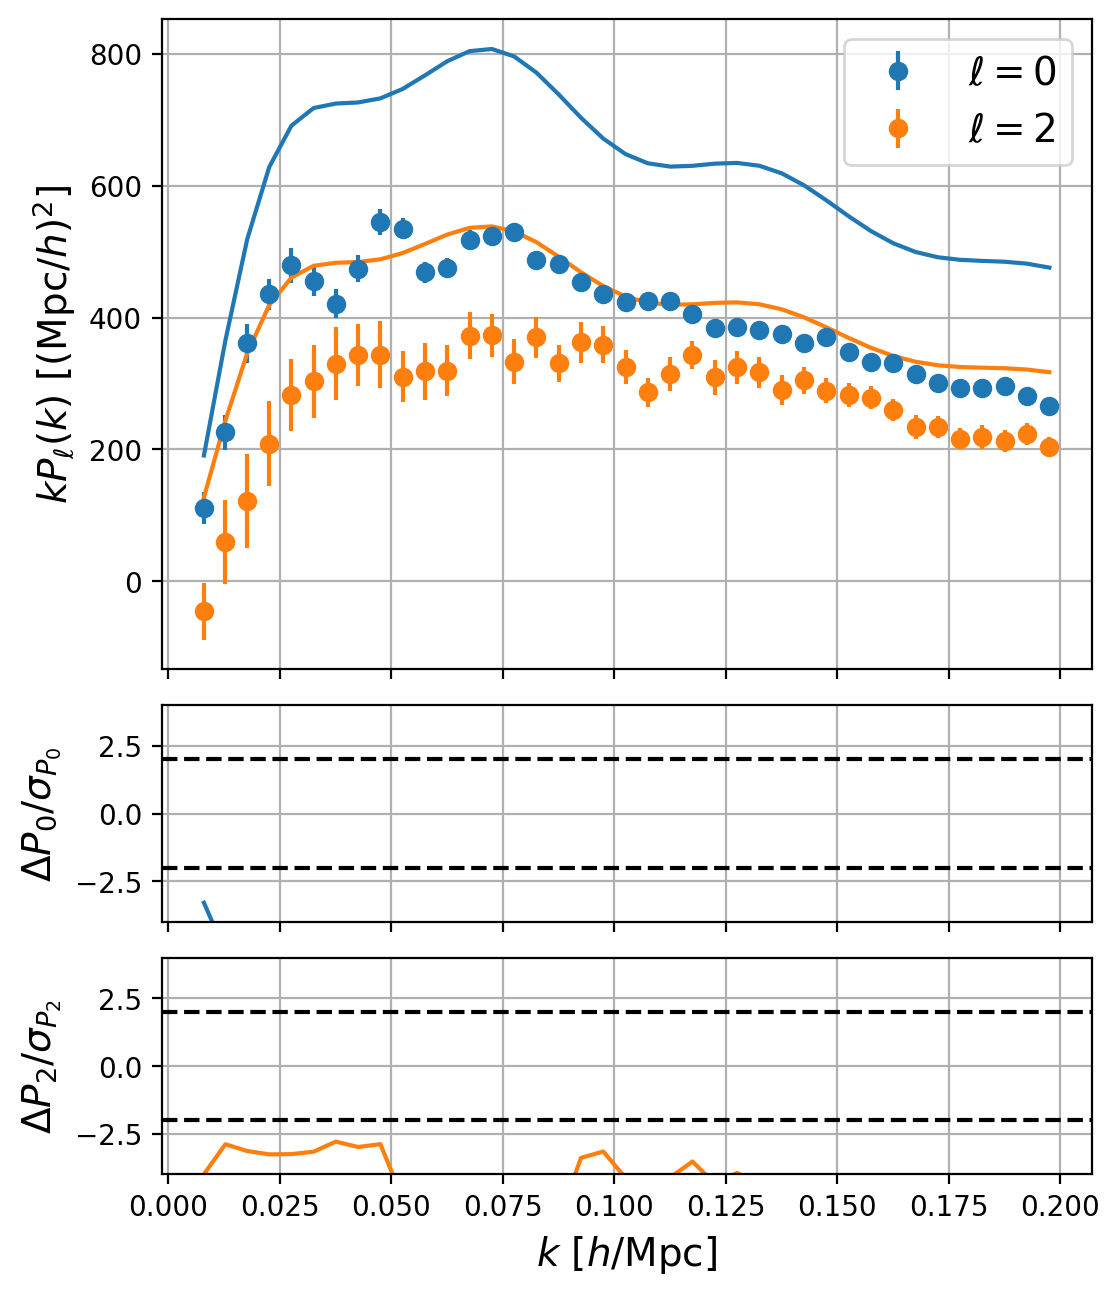

In [4]:
fig_cov = observable.plot_covariance_matrix()
fig_pk = observable.plot()